In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

## Read data into scanpy and add in metadata

In [2]:
# we see 62k cells and 20k genes
expr = sc.read_csv("expMatrix.csv", first_column_names=True)
expr

AnnData object with n_obs × n_vars = 62167 × 20223

In [3]:
meta = pd.read_csv("geo_metadata.csv")
meta.head()
id_to_timepoint_type = dict(zip(meta["id_in_expmatrix"].astype(str), meta["time_point_type"]))
id_to_disease_state = dict(zip(meta["id_in_expmatrix"].astype(str), meta["disease_state"]))
id_to_patient_id = dict(zip(meta["id_in_expmatrix"].astype(str), meta["patient_id"]))

expr.obs["sample_id"] = [barcode.split("-")[-1] for barcode in expr.obs.index]
expr.obs["disease_state"] = expr.obs["sample_id"].map(id_to_disease_state)
expr.obs["time_point_type"] = expr.obs["sample_id"].map(id_to_timepoint_type)
expr.obs["patient_id"] = expr.obs["sample_id"].map(id_to_patient_id)
expr.obs["patient_timepoint"] = expr.obs["patient_id"] + "-" + expr.obs["time_point_type"]
expr.obs["outcome"] = expr.obs["patient_id"].map(dict(zip(meta["patient_id"], meta["Outcome"])))
expr.obs["status"] = expr.obs["patient_id"].map(dict(zip(meta["patient_id"], meta["DFS/PFS_Status"])))

## Quality Control
* filter cells with < 200 genes
* filter genes with < 3 cells
* filter cells with > 10% mitochodrial genes

In [4]:
expr.var['mt'] = expr.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(expr, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
expr.obs.head()

,sample_id,disease_state,time_point_type,patient_id,patient_timepoint,outcome,status,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGAGCGTCTAT-1,1,CLL,IP,CLL-1,CLL-1-IP,CR,CR_Ongoing,2500,8780.0,333.0,3.792711
AAACCTGCAATAGAGT-1,1,CLL,IP,CLL-1,CLL-1-IP,CR,CR_Ongoing,2549,8782.0,739.0,8.414940
AAACCTGCATGACGGA-1,1,CLL,IP,CLL-1,CLL-1-IP,CR,CR_Ongoing,3146,10911.0,540.0,4.949134
AAACCTGGTAGTGAAT-1,1,CLL,IP,CLL-1,CLL-1-IP,CR,CR_Ongoing,4310,18042.0,1167.0,6.468241
AAACCTGGTCTCCCTA-1,1,CLL,IP,CLL-1,CLL-1-IP,CR,CR_Ongoing,4628,24558.0,1217.0,4.955615


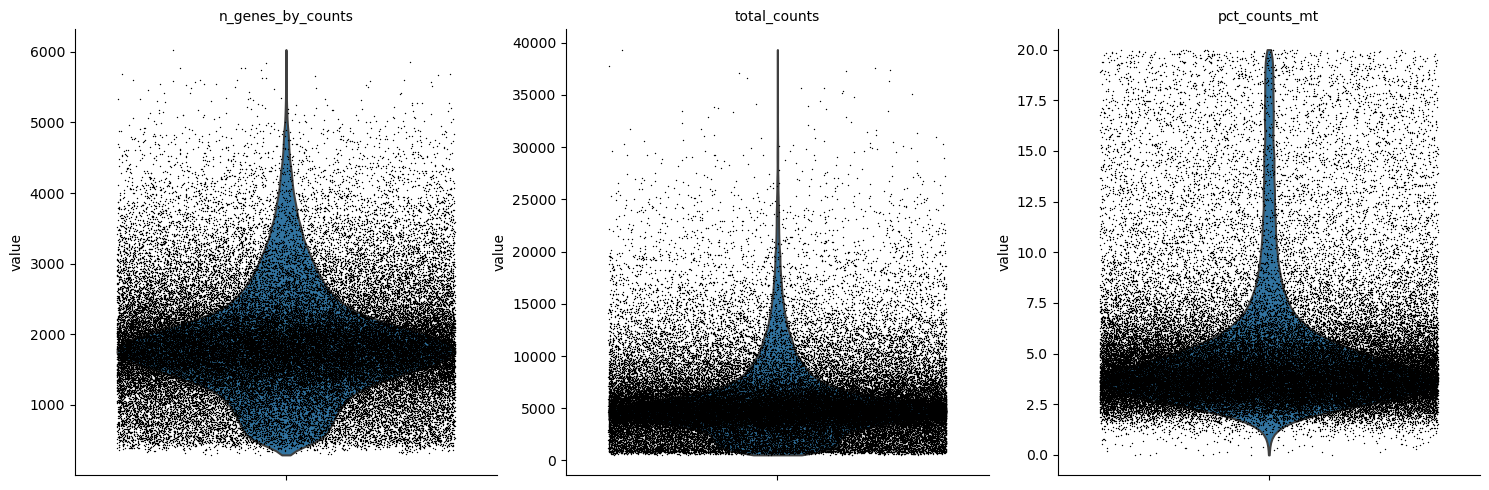

In [5]:
# n_genes_by_counts: Number of genes expressed in each cell (we filter out those with < 200)
# pct_counts_mt: Percentage of reads in each cell that are mitochondrial
# also filter out cells with >10% mitochondrial reads
sc.pp.filter_cells(expr, min_genes=200)
sc.pp.filter_genes(expr, min_cells=3)
sc.pl.violin(expr, ['n_genes_by_counts', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [6]:
expr = expr[expr.obs.n_genes_by_counts > 200,]
expr = expr[expr.obs.pct_counts_mt < 10,]

## Normalization
* normalize data to log(CPM+1)
* look at highly variable genes
* scale normalize the data

In [7]:
sc.pp.normalize_total(expr)
sc.pp.log1p(expr)
expr.raw = expr


/Users/elanasimon/miniconda3/envs/bmi/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
# notice that most of the high variable genes are TRB genes
sc.pp.highly_variable_genes(expr)
expr.var['trb'] = expr.var_names.str.startswith('TRB')
expr.var.loc[expr.var.highly_variable].sort_values("dispersions", ascending=False).head(10)

,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,trb
S100A9,False,77,0.019689,99.876140,1224.0,77,True,0.013921,4.757143,14.140092,False
TRBV7-2,False,2294,0.481992,96.309939,29964.0,2294,True,0.377325,3.484430,8.916879,True
TRBV10-3,False,1090,0.326942,98.246658,20325.0,1090,True,0.281928,3.357422,8.565622,True
MTRNR2L12,False,58496,8.922001,5.905062,554654.0,58496,True,2.325795,3.318659,3.073340,False
LYZ,False,368,0.034472,99.408046,2143.0,368,True,0.022269,3.287997,9.632686,False
TRBV7-3,False,1243,0.280921,98.000547,17464.0,1243,True,0.243818,3.256322,8.286018,True
TRBV4-1,False,2035,0.489408,96.726559,30425.0,2035,True,0.405404,3.205354,8.145060,True
TRBV11-2,False,2305,0.617900,96.292245,38413.0,2305,True,0.462127,3.176631,8.065622,True
TRBV12-3,False,1589,0.389178,97.443982,24194.0,1589,True,0.329502,3.121294,7.912581,True
TRBV13,False,1036,0.254122,98.333521,15798.0,1036,True,0.204568,3.077064,8.985533,True


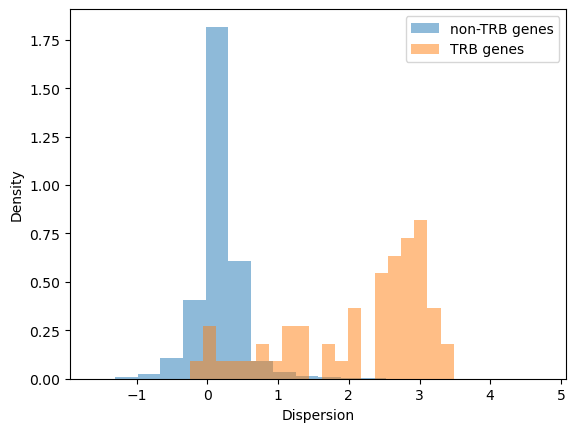

In [9]:
plt.hist(data=expr.var.loc[~expr.var.trb], x="dispersions", label="non-TRB genes", density=True, alpha=0.5, bins=20)
plt.hist(data=expr.var.loc[expr.var.trb], x="dispersions", label="TRB genes", density=True, alpha=0.5, bins=20)
plt.xlabel("Dispersion")
plt.ylabel("Density")
plt.legend()
plt.show()

In [10]:
sc.pp.scale(expr, max_value=10)

## Save final processed file

In [11]:
# save scanpy object for later use
expr.write("expr_preprocessed.h5ad")